# DOW Clustering

This notebook aims to perform a clustering analysis regarding customer activity, specifically the number of orders they made throughout the days of the week, their age, and other various factors.

The notebook will be organized as follows:

### 1. Data Preprocessing;

### 2. Number of Clusters

      2.1 Evaluate the Number of Clusters with K means

      2.2 Evaluate the Number of Clusters graphically whit the Dendogram

### 3. K-means Clustering

### 4. Hierarchical Clustering

### 5. Cluster Profile (Best Result)

      5.1 Number of Customers per Cluster

      5.2 City as a Factor

      5.3 Age as a Factor

      5.4 Paymenth Methods as  Factor

      5.5 Comparing Clusters with the Entire Dataset

      5.6 Final Cluster Profile

In [60]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Clustering and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from scipy.cluster.hierarchy import dendrogram

# Custom Modules
import sys
sys.path.append('../Functions')  # Adjust the path to your custom module directory
import CleanUp as p  # Importing custom CleanUp module

# Miscellaneous
import math




In [84]:
filepath = '../Data/DM2425_ABCDEats_DATASET.csv'
# Load the raw data
raw_data = pd.read_csv(filepath)
df, columns_dict = p.cleanUp(raw_data)

-----------looking for incostisencies -----------
There are repeated values in the dataset
      customer_id customer_region  customer_age  vendor_count  product_count  \
20855  742ca068fc            8550          20.0             1              2   
20907  742ca068fc            8550          20.0             1              2   

       is_chain  first_order  last_order last_promo payment_method  ...  \
20855         0         35.0          35          -           CARD  ...   
20907         0         35.0          35          -           CARD  ...   

       HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  
20855      0      0      0      0      0      0      0      0      0      0  
20907      0      0      0      0      0      0      0      0      0      0  

[2 rows x 56 columns]
There are inconsistencies between DOW and HR columns
1553.0
filling HR_0
-----------identify the numerical columns -----------
primary_key is not numerical
-----------Identify the non n

In [85]:
key = columns_dict.keys()
print(key)
new_features_list = columns_dict['new_features_list']
numerical_columns = columns_dict['numerical_columns']
CUI_col = columns_dict['CUI_col']
HR_col = columns_dict['HR_col']
DOW_col = columns_dict['DOW_col']

dict_keys(['non_numerical_columns', 'new_features_list', 'numerical_columns', 'CUI_col', 'HR_col', 'DOW_col'])


## 1. Data Processing

In [86]:
# Keep only the columns that are needed for the cluster
fixed_columns = ["customer_city", "customer_age", "payment_method"]

# Combine and select
selected_columns = df[fixed_columns + DOW_col]

cluster_df = df[fixed_columns + DOW_col]

In [87]:
cluster_df

,customer_city,customer_age,payment_method,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
0,2,18.0,DIGI,1,0,0,0,0,0,1
1,8,17.0,DIGI,1,0,0,0,0,0,1
2,4,38.0,CASH,1,0,0,0,0,0,1
3,4,26.0,DIGI,0,1,0,0,0,0,1
4,4,20.0,DIGI,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
31883,8,30.0,DIGI,0,0,0,0,0,0,1
31884,8,26.0,DIGI,0,0,0,0,0,0,1
31885,8,24.0,DIGI,0,0,0,0,0,0,1
31886,8,34.0,DIGI,0,0,0,0,0,0,1


In [88]:
cluster_df["customer_age"].min()

15.0

In [89]:
# Removing people above 53 years old and below 15 years old
cluster_df = cluster_df[(cluster_df['customer_age'] <= 52)]

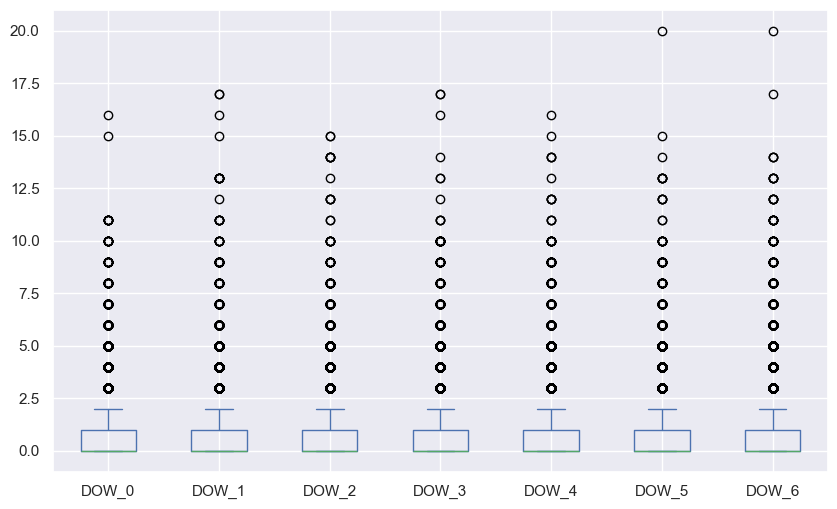

In [90]:
# see the distribution of the Dow Columns
cluster_df[DOW_col].plot(kind='box', figsize=(10, 6))
plt.show()

Despite of having multiple outliers, we will not remove them because we want to clearly see what at our top clients through the clustering techniques

In [91]:
features_to_cluster = ["DOW_0", "DOW_1", "DOW_2", "DOW_3", "DOW_4", "DOW_5", "DOW_6"]
features_not_to_cluster = ["customer_city", "customer_age", "payment_method"]

In [92]:
cluster_df[features_to_cluster].isna().sum()

DOW_0    0
DOW_1    0
DOW_2    0
DOW_3    0
DOW_4    0
DOW_5    0
DOW_6    0
dtype: int64

In [93]:
print(cluster_df[DOW_col].dtypes)

DOW_0    int64
DOW_1    int64
DOW_2    int64
DOW_3    int64
DOW_4    int64
DOW_5    int64
DOW_6    int64
dtype: object


In [94]:
# Scale Dow Columns Custom
scaler = StandardScaler()
cluster_df[DOW_col] = scaler.fit_transform(cluster_df[DOW_col])
cluster_df[DOW_col]

C:\Users\andre\AppData\Local\Temp\ipykernel_21168\3232350076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df[DOW_col] = scaler.fit_transform(cluster_df[DOW_col])


,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
0,0.435752,-0.544737,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
1,0.435752,-0.544737,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
2,0.435752,-0.544737,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
3,-0.549749,0.412203,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
4,-0.549749,0.412203,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
...,...,...,...,...,...,...,...
31883,-0.549749,-0.544737,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
31884,-0.549749,-0.544737,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
31885,-0.549749,-0.544737,-0.567114,-0.580866,-0.624579,-0.611858,0.250273
31886,-0.549749,-0.544737,-0.567114,-0.580866,-0.624579,-0.611858,0.250273


In [95]:
print(round(cluster_df[DOW_col].mean()))
print(round(cluster_df[DOW_col].std()))

DOW_0    0.0
DOW_1   -0.0
DOW_2    0.0
DOW_3    0.0
DOW_4    0.0
DOW_5   -0.0
DOW_6    0.0
dtype: float64
DOW_0    1.0
DOW_1    1.0
DOW_2    1.0
DOW_3    1.0
DOW_4    1.0
DOW_5    1.0
DOW_6    1.0
dtype: float64


## 2. Number of Clusters

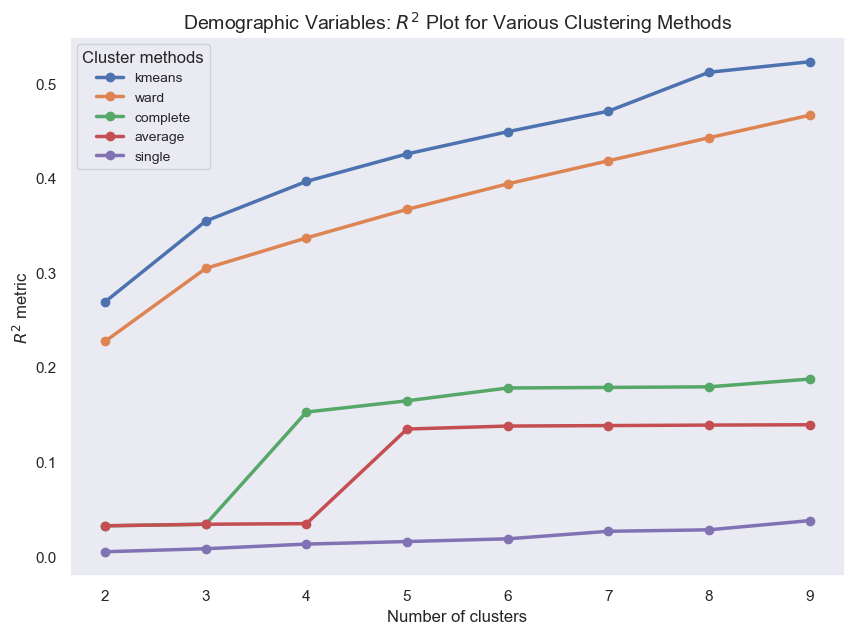

In [108]:
# Clustering methods
methods = {
    'kmeans': lambda n: KMeans(n_clusters=n, random_state=42).fit_predict(cluster_df[features_to_cluster]),
    'ward': lambda n: AgglomerativeClustering(n_clusters=n, linkage='ward').fit_predict(cluster_df[features_to_cluster]),
    'complete': lambda n: AgglomerativeClustering(n_clusters=n, linkage='complete').fit_predict(cluster_df[features_to_cluster]),
    'average': lambda n: AgglomerativeClustering(n_clusters=n, linkage='average').fit_predict(cluster_df[features_to_cluster]),
    'single': lambda n: AgglomerativeClustering(n_clusters=n, linkage='single').fit_predict(cluster_df[features_to_cluster]),
}

# Range of cluster numbers
cluster_range = range(2, 10)
results = {method: [] for method in methods}

# Helper functions for calculating R^2
def get_ss(df, feats):
    data = df[feats].to_numpy()
    overall_mean = np.mean(data, axis=0)
    sst = np.sum((data - overall_mean) ** 2)
    return sst

def get_ssw(df, feats, labels):
    ssw = 0.0
    for cluster in np.unique(labels):
        cluster_data = df[feats].to_numpy()[labels == cluster]
        cluster_mean = np.mean(cluster_data, axis=0)
        ssw += np.sum((cluster_data - cluster_mean) ** 2)
    return ssw

def get_rsq(df, feats, labels):
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, labels)
    ssb = sst - ssw
    return ssb / sst

# Compute R^2 for each method and number of clusters
for method, clustering_func in methods.items():
    for n_clusters in cluster_range:
        # Perform clustering and get labels
        labels = clustering_func(n_clusters)
        # Calculate R^2
        r2 = get_rsq(cluster_df, features_to_cluster, labels)
        results[method].append(r2)

# Plot the results
plt.figure(figsize=(10, 7))
for method, r2_values in results.items():
    plt.plot(
        cluster_range,
        r2_values,
        label=method,
        linewidth=2.5,
        marker="o"  # Use marker parameter for points
    )

# Customize the plot
plt.title(r'Demographic Variables: $R^2$ Plot for Various Clustering Methods', fontsize=14)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel(r'$R^2$ metric', fontsize=12)
plt.legend(title="Cluster methods", fontsize=10)
plt.grid()

# Display the plot
plt.show()


Here we can see that in terms of the R2 metric the K-means clustering aproach is the one who gets the best results.

In the aggloremative clustering aproach the "ward" method is the one who achieves the best results. For this method, the R2 metric increases sharply up to 4 clusters, after which the rate of improvement slows down.

### 2.1 Evaluate the Number of Clusters with K means

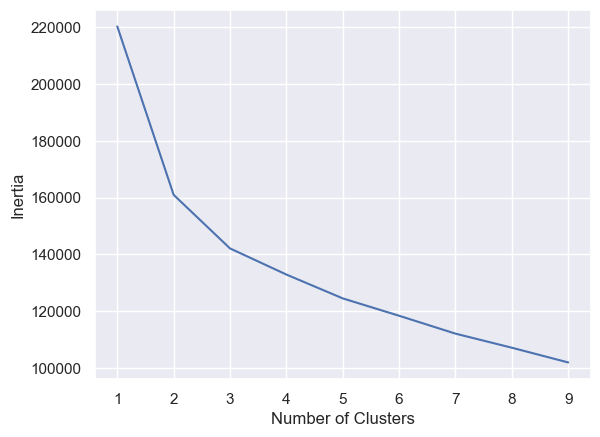

In [97]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(cluster_df[features_to_cluster])
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()

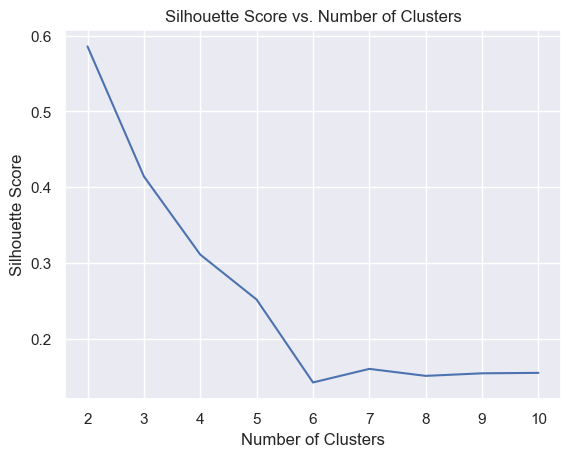

In [98]:
s_scores = []
n_clusters = range(2, 11)
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=94)  # Set random_state for reproducibility
    kmeans.fit(cluster_df[features_to_cluster])
    score = silhouette_score(cluster_df[features_to_cluster], kmeans.labels_)
    s_scores.append(score)

# Plot silhouette scores dynamically
plt.figure()  # Create a new figure for each iteration
plt.plot(n_clusters, s_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Number of Clusters')
plt.show()

**Through the elbow graph, we can see that the optimal number of clusters is 3, and the silhouette score we can see that the optimal number of clusters with the k means is 2.**

### 2.2 Evaluate the Number of Clusters graphically whit the Dendogram

In [109]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = "ward" 
distance = "euclidean" 


hclust = AgglomerativeClustering(linkage = linkage, metric=distance, distance_threshold=0, n_clusters=None) 
hclust.fit_predict(cluster_df[features_to_cluster])

array([31458, 19961, 31457, ...,     3,     1,     0], dtype=int64)

In [110]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

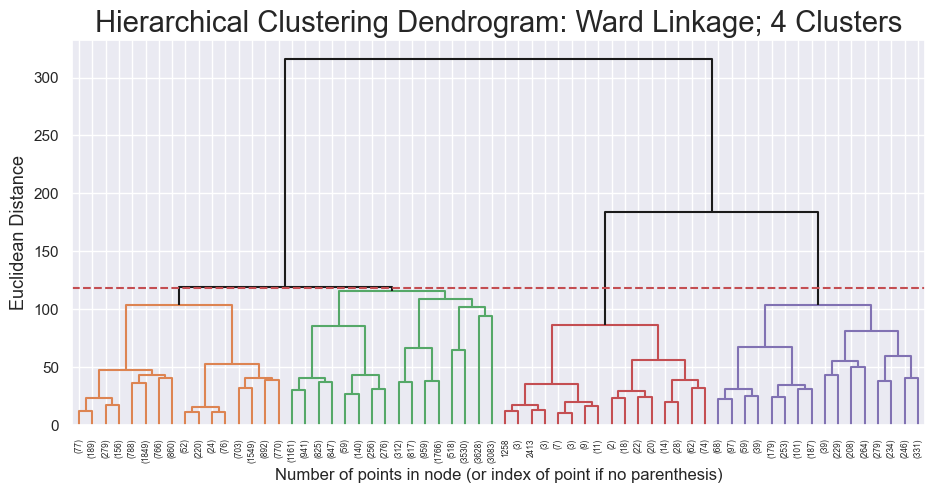

In [111]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 118
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage; 4 Clusters', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

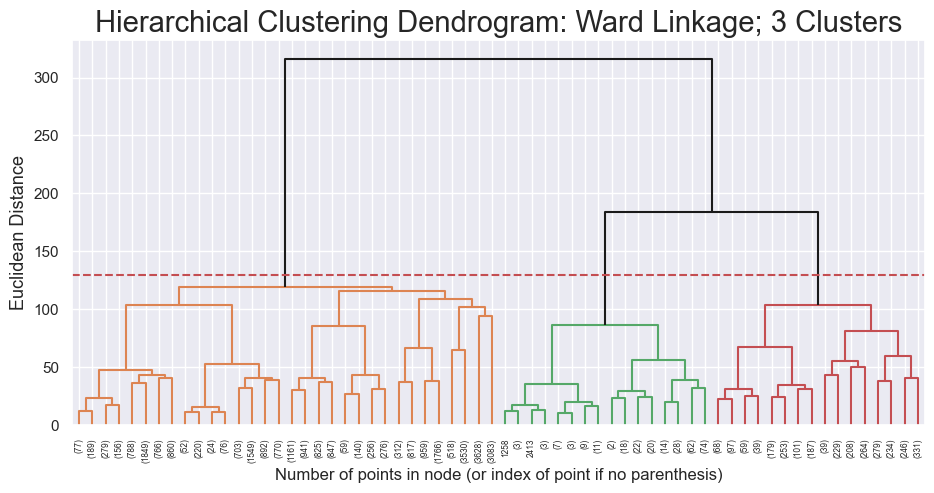

In [112]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 130
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage; 3 Clusters', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

Visually, the dendrogram seems to suggest that the optimal number of clusters is either 3 or 4.

In this case, we will perform clustering using the K-Means algorithm with 2 and 3 clusters, and with the Agglomerative Clustering algorithm using 3 and 4 clusters.

Finally, we will conduct a metric evaluation for each Cluster and make a decision based on this evaluation, but also considering the marketing insights provided by these clustering results.

## 3. K-means Clustering

C:\Users\andre\AppData\Local\Temp\ipykernel_21168\4193754706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['K_Means_2_clusters'] = k_means_predictions


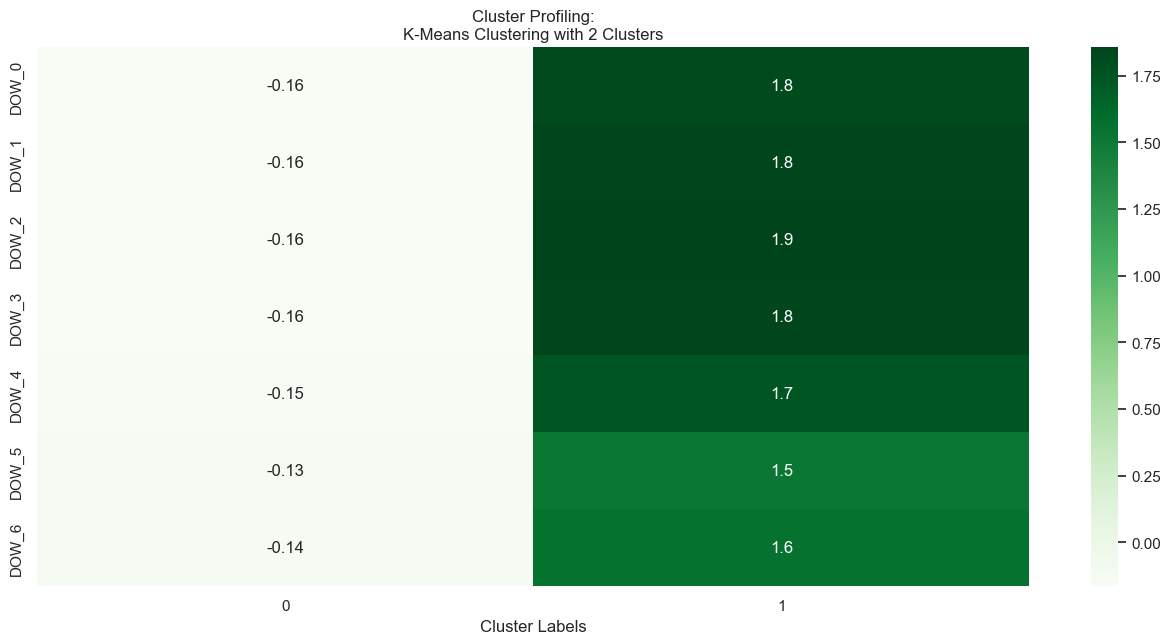

In [114]:
# Lets use 2 clusters
km = KMeans(n_clusters=2, init="k-means++", random_state=94)

km.fit(cluster_df[features_to_cluster])
k_means_predictions = km.predict(cluster_df[features_to_cluster])
cluster_df['K_Means_2_clusters'] = k_means_predictions

cluster_df[features_to_cluster + ['K_Means_2_clusters']].groupby('K_Means_2_clusters').mean()
fig, ax = plt.subplots(figsize=(16,7))

sns.heatmap(cluster_df[features_to_cluster + ['K_Means_2_clusters']].groupby('K_Means_2_clusters').mean().T,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nK-Means Clustering with 2 Clusters")
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_21168\3443352455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['K_Means_3_clusters'] = k_means_predictions


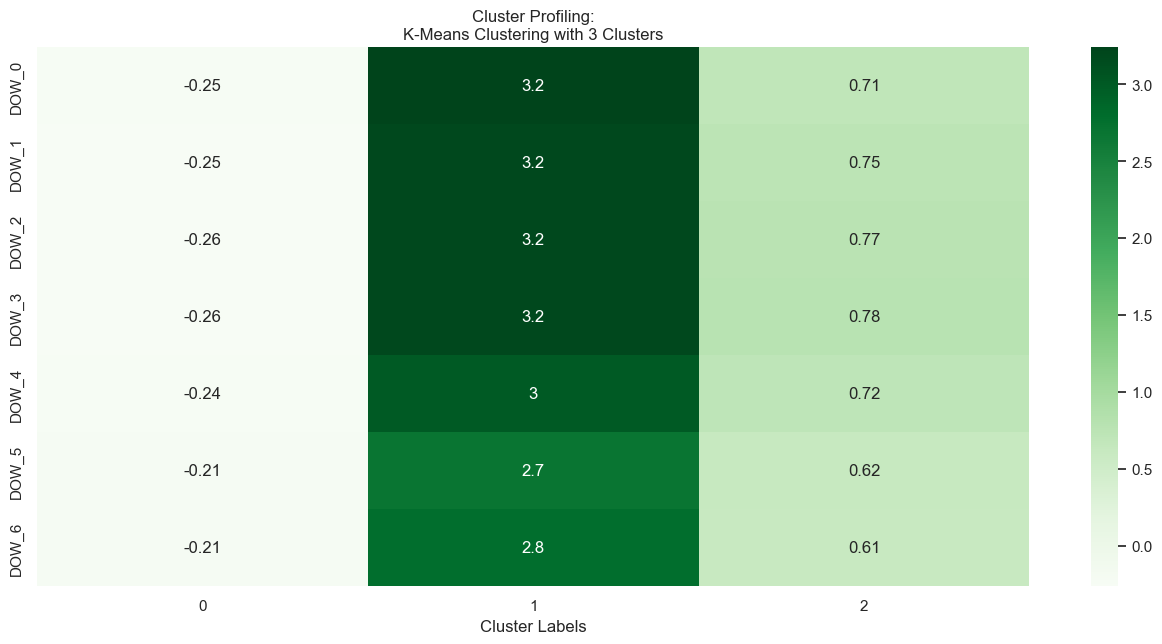

In [115]:
# Lets use 3 clusters
km = KMeans(n_clusters=3, init="k-means++", random_state=94)

km.fit(cluster_df[features_to_cluster])
k_means_predictions = km.predict(cluster_df[features_to_cluster])
cluster_df['K_Means_3_clusters'] = k_means_predictions

cluster_df[features_to_cluster + ['K_Means_3_clusters']].groupby('K_Means_3_clusters').mean()
fig, ax = plt.subplots(figsize=(16,7))

sns.heatmap(cluster_df[features_to_cluster + ['K_Means_3_clusters']].groupby('K_Means_3_clusters').mean().T,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nK-Means Clustering with 3 Clusters")
plt.show()

## 4. Hierarchical Clustering

[0 0 0 ... 0 0 0]


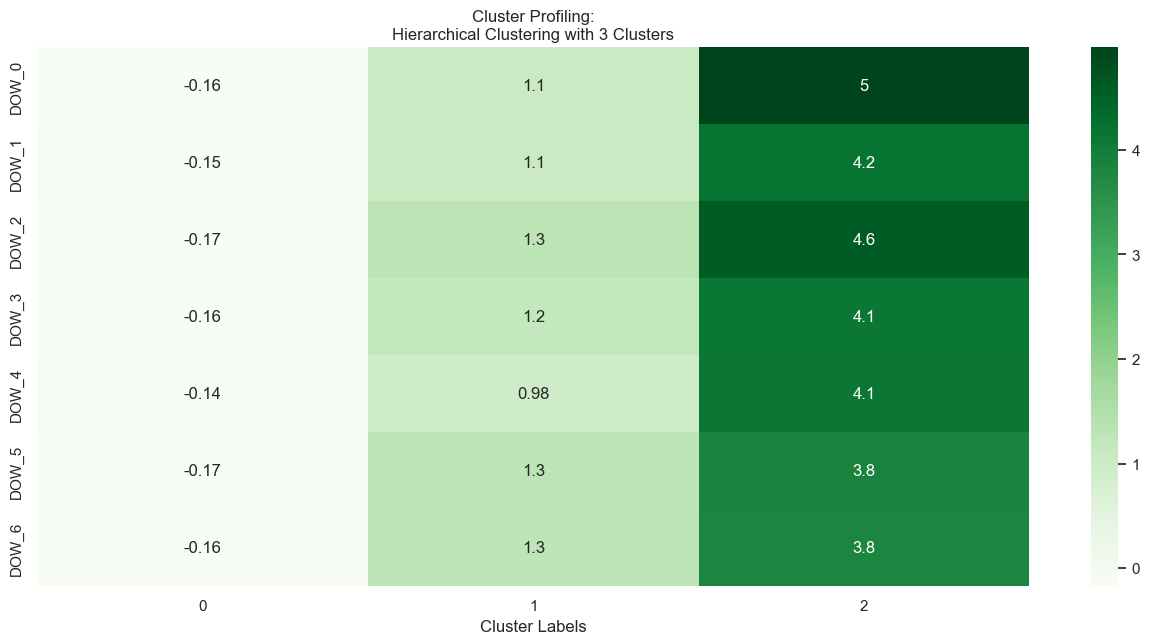

In [116]:
# 3 Clusters
hclust_3 = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
hc_labels_3 = hclust_3.fit_predict(cluster_df[features_to_cluster])
print(hc_labels_3)

labels_series = pd.Series(hc_labels_3, 
                          name='Hierarchical_Clustering_3_Clusters', 
                          index=cluster_df[features_to_cluster].index 
                          ) 

cluster_df = pd.concat(
    [cluster_df, labels_series],
    axis=1)

fig, ax = plt.subplots(figsize=(16,7))

hc_profile = cluster_df.groupby('Hierarchical_Clustering_3_Clusters')[features_to_cluster].mean().T

sns.heatmap(hc_profile,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()

[3 3 3 ... 3 3 3]


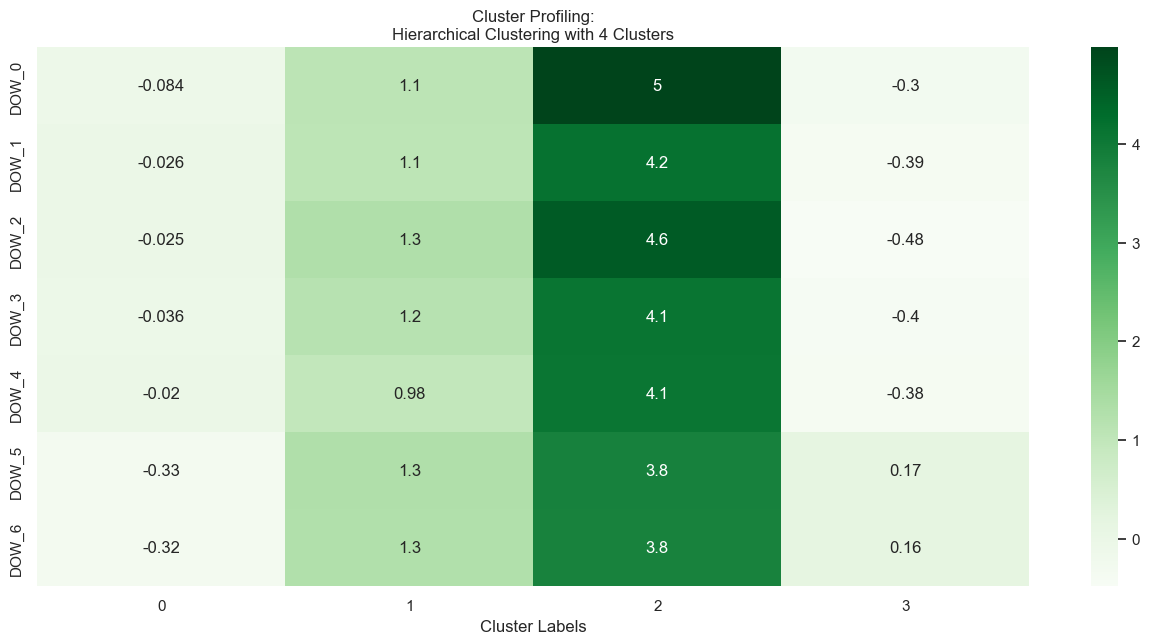

In [117]:
# 4 clusters
hclust_4 = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
hc_labels_4 = hclust_4.fit_predict(cluster_df[features_to_cluster])
print(hc_labels_4)

labels_series = pd.Series(hc_labels_4, 
                          name='Hierarchical_Clustering_4_Clusters', 
                          index=cluster_df[features_to_cluster].index 
                          ) 

cluster_df = pd.concat(
    [cluster_df, labels_series],
    axis=1)

fig, ax = plt.subplots(figsize=(16,7))

hc_profile = cluster_df.groupby('Hierarchical_Clustering_4_Clusters')[features_to_cluster].mean().T

sns.heatmap(hc_profile,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 4 Clusters")
plt.show()



In [118]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

cluster_columns = cluster_df.columns[-4:].tolist()
# Initialize an empty list to store results
results = []

for col in cluster_columns:  # Assuming each column represents a clustering result
    labels = cluster_df[col]
    silhouette = silhouette_score(cluster_df[features_to_cluster], labels)
    calinski_harabasz = calinski_harabasz_score(cluster_df[features_to_cluster], labels)
    davies_bouldin = davies_bouldin_score(cluster_df[features_to_cluster], labels)
    
    # Store the results in a dictionary
    results.append({
        "Cluster": col,
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Index": calinski_harabasz,
        "Davies-Bouldin Index": davies_bouldin
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Display the resulting DataFrame
results_df

,Cluster,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,K_Means_2_clusters,0.585746,11583.146379,1.221077
1,K_Means_3_clusters,0.397727,8640.319007,1.634661
2,Hierarchical_Clustering_3_Clusters,0.487972,6885.516076,1.434239
3,Hierarchical_Clustering_4_Clusters,0.054491,5322.196832,2.127432


The 4 clusters dispite of beeing the lowest in terms of metrics seems to be the most interisting one in terms of pattern. Lets try to see a 4 cluster with K-means.

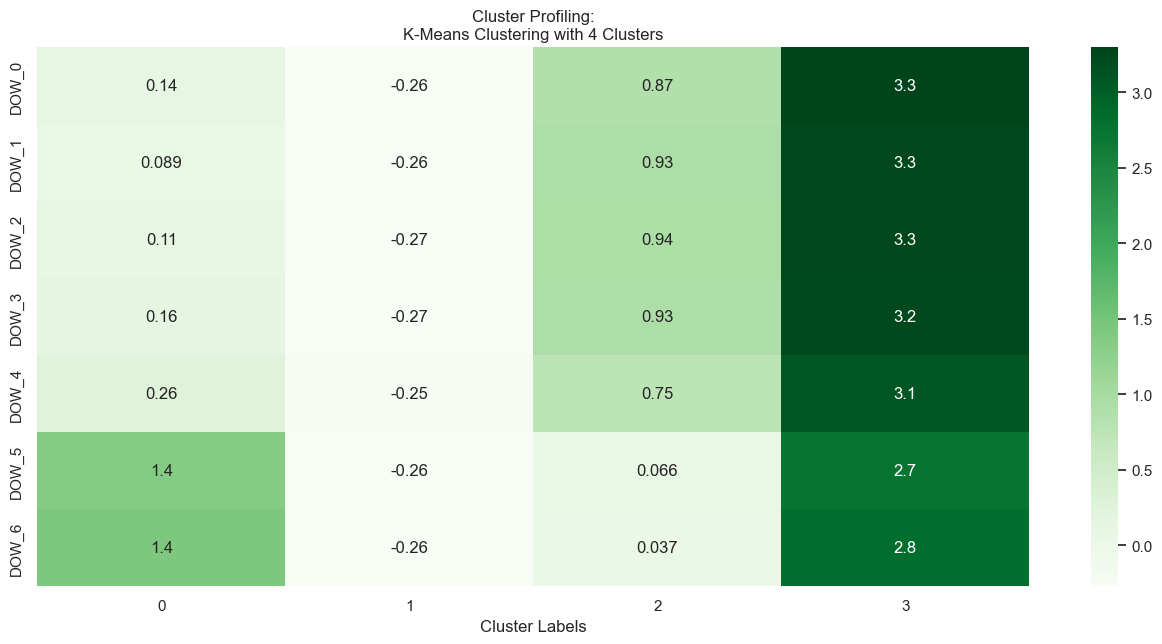

In [119]:
# Lets use 3 clusters
km = KMeans(n_clusters=4, init="k-means++", random_state=96)
km.fit(cluster_df[features_to_cluster])
k_means_predictions = km.predict(cluster_df[features_to_cluster])
cluster_df['K_Means_4_clusters'] = k_means_predictions

cluster_df[features_to_cluster + ['K_Means_4_clusters']].groupby('K_Means_4_clusters').mean()
fig, ax = plt.subplots(figsize=(16,7))

sns.heatmap(cluster_df[features_to_cluster + ['K_Means_4_clusters']].groupby('K_Means_4_clusters').mean().T,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nK-Means Clustering with 4 Clusters")
plt.show()

In [120]:
# Calculate the silhouette score
silhouette = silhouette_score(cluster_df[features_to_cluster], cluster_df["K_Means_4_clusters"])
print(f'Silhouette Score for the last column: {silhouette}')

Silhouette Score for the last column: 0.3545611602705225


In [121]:
cluster_columns = cluster_df.columns[-5:].tolist()
# Initialize an empty list to store results
results = []

for col in cluster_columns:  # Assuming each column represents a clustering result
    labels = cluster_df[col]
    silhouette = silhouette_score(cluster_df[features_to_cluster], labels)
    calinski_harabasz = calinski_harabasz_score(cluster_df[features_to_cluster], labels)
    davies_bouldin = davies_bouldin_score(cluster_df[features_to_cluster], labels)
    
    # Store the results in a dictionary
    results.append({
        "Cluster": col,
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Index": calinski_harabasz,
        "Davies-Bouldin Index": davies_bouldin
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Display the resulting DataFrame
results_df

,Cluster,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,K_Means_2_clusters,0.585746,11583.146379,1.221077
1,K_Means_3_clusters,0.397727,8640.319007,1.634661
2,Hierarchical_Clustering_3_Clusters,0.487972,6885.516076,1.434239
3,Hierarchical_Clustering_4_Clusters,0.054491,5322.196832,2.127432
4,K_Means_4_clusters,0.354561,6833.795037,1.770696


### Conclusion
    
    K-Means with 4 clusters outperforms Hierarchical clustering with 4 clusters in all three metrics: Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index. Thus, K-Means with 4 clusters does improve the clustering results compared to Hierarchical clustering with 4 clusters.

    In addition, in terms of insights for customer segmentation analysis and marketing strategies, the result of the K-means with 4 clusters reveals much more interesting patterns, and for this reason, it will be used.




## 5. Cluster Profiling

In [122]:
# Lets do an inverse scaling to see the real mean of the features that were clustered
cluster_df[DOW_col] = scaler.inverse_transform(cluster_df[DOW_col])
# Round and put it back to intenger type
cluster_df[DOW_col] = cluster_df[DOW_col].round(0).astype(int)

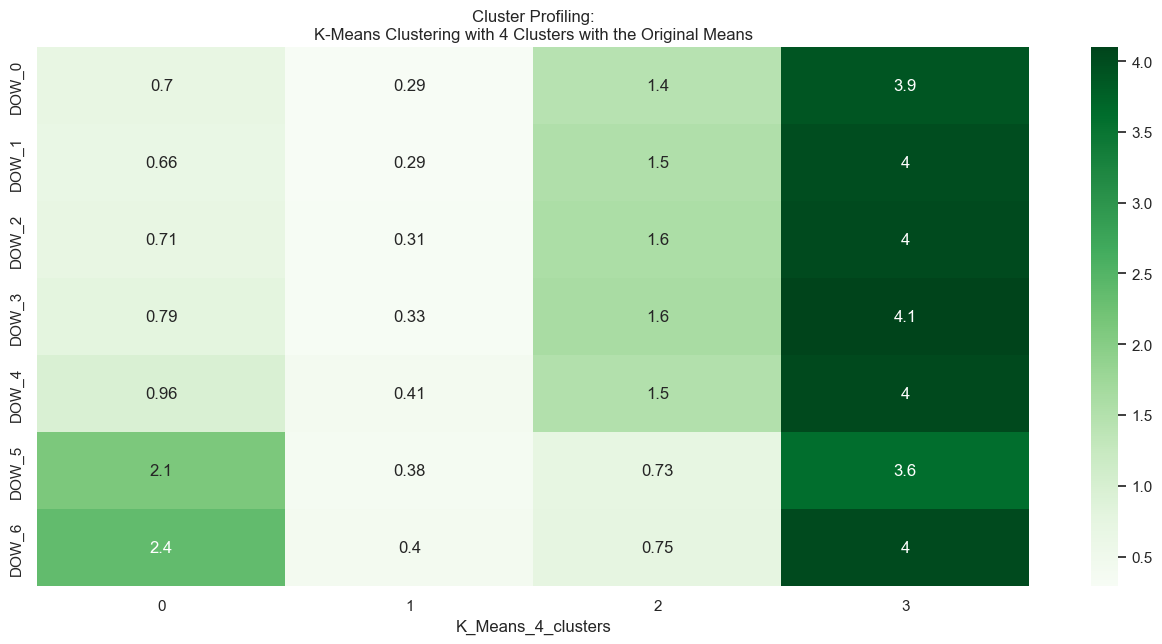

In [123]:
#Vizualize the cluster with the real means
fig, ax = plt.subplots(figsize=(16, 7))

sns.heatmap(cluster_df[features_to_cluster + ['K_Means_4_clusters']].groupby('K_Means_4_clusters').mean().T,
            ax=ax,
            cmap='Greens',
            annot=True
            ) 


ax.set_title("Cluster Profiling:\nK-Means Clustering with 4 Clusters with the Original Means")
plt.show()

### Purchasing Patterns by Cluster

Based on the K-means clustering with 4 clusters, the purchasing behavior can be summarized as follows:

#### 1. **End of the Week Shoopers (Cluster 0)**
- **Pattern**: Customers in this cluster have a medium activity of orders placed during the midweek and have significantly increase in orders placed on Friday and Saturday.
- **Peak**: Saturday (DOW_6).
- **Trend**: Increased purchasing activity towards the weekend, peaking on Saturday, and a notable rise on Friday.

#### 2. **Low Orders Shoopers (Cluster 1)**
- **Pattern**: Customers in this cluster place the fewest orders across the week, with consistently low values throughout the days.
- **Peak**: Satuday (DOW_6), but not siginificant
- **Trend**: Orders remain low throughout the entire week, with the highest value on Saturday, showing little variation across the days.

#### 3. **Weekday Shoopers (Cluster 2)**
- **Pattern**: Customers in this cluster show a regular high number of orders placed throughout Sunday and the weekdays, with a decrease in the end of the week (Friday and Saturday).
- **Peak**: Tuesday (DOW_2) and Wednesday (DOW_3).
- **Trend**: Orders increase through the weekdays, with a peak on Wednesday and a relatively steady decline towards the weekend.

#### 4. **High Activity Shoopers (Cluster 3)**
- **Pattern**: This group shows very high activitys in orders placed throughout the entire week.
- **Peak**: Wednesday (DOW_3).
- **Trend**: Shoopers with the highest activity.

### 5.1 Percentage of Customers per Cluster

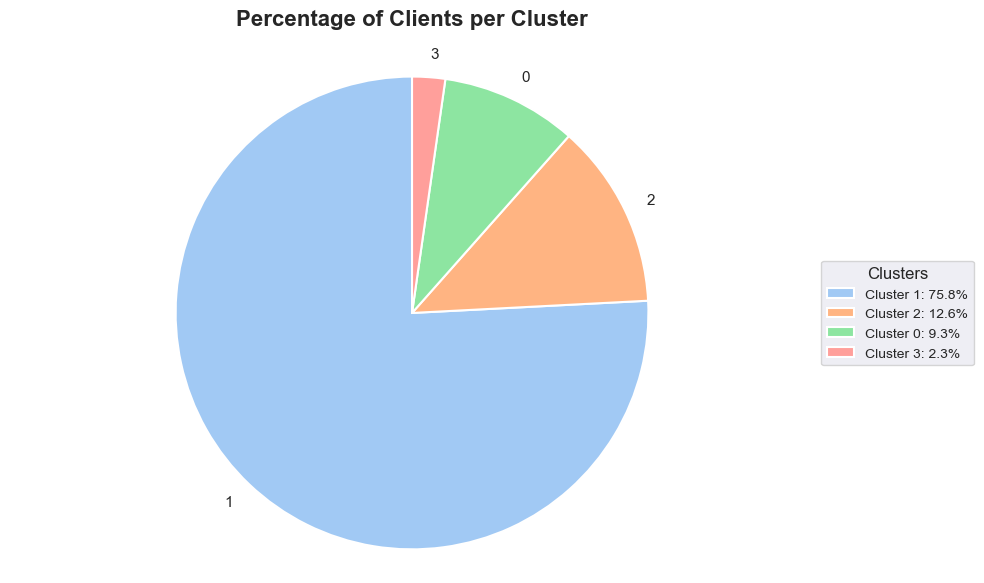

In [124]:
# Count the number of rows for each cluster
cluster_counts = cluster_df["K_Means_4_clusters"].value_counts()

# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the pie chart without percentages
wedges, texts = ax.pie(
    cluster_counts, 
    labels=[f"{i}" for i in cluster_counts.index],  # Cluster labels
    startangle=90, 
    colors=sns.color_palette("pastel"),  # Pastel colors for a clean look
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}  # Add edge for clarity
)

# Create a legend with only percentages
cluster_percentages = [f"Cluster {i}: {count / cluster_counts.sum() * 100:.1f}%" 
                       for i, count in zip(cluster_counts.index, cluster_counts)]

# Add the legend outside the pie chart
ax.legend(
    labels=cluster_percentages, 
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    title="Clusters", 
    title_fontsize=12, 
    fontsize=10
)

# Add a title with better styling
plt.title('Percentage of Clients per Cluster', fontsize=16, weight='bold', pad=20)

# Ensure the pie chart is a circle
ax.axis('equal')

# Optimize layout
plt.tight_layout()
plt.show()

**We can observe that the majority of customers belong to cluster 1.**

### 5.2 City as a Factor

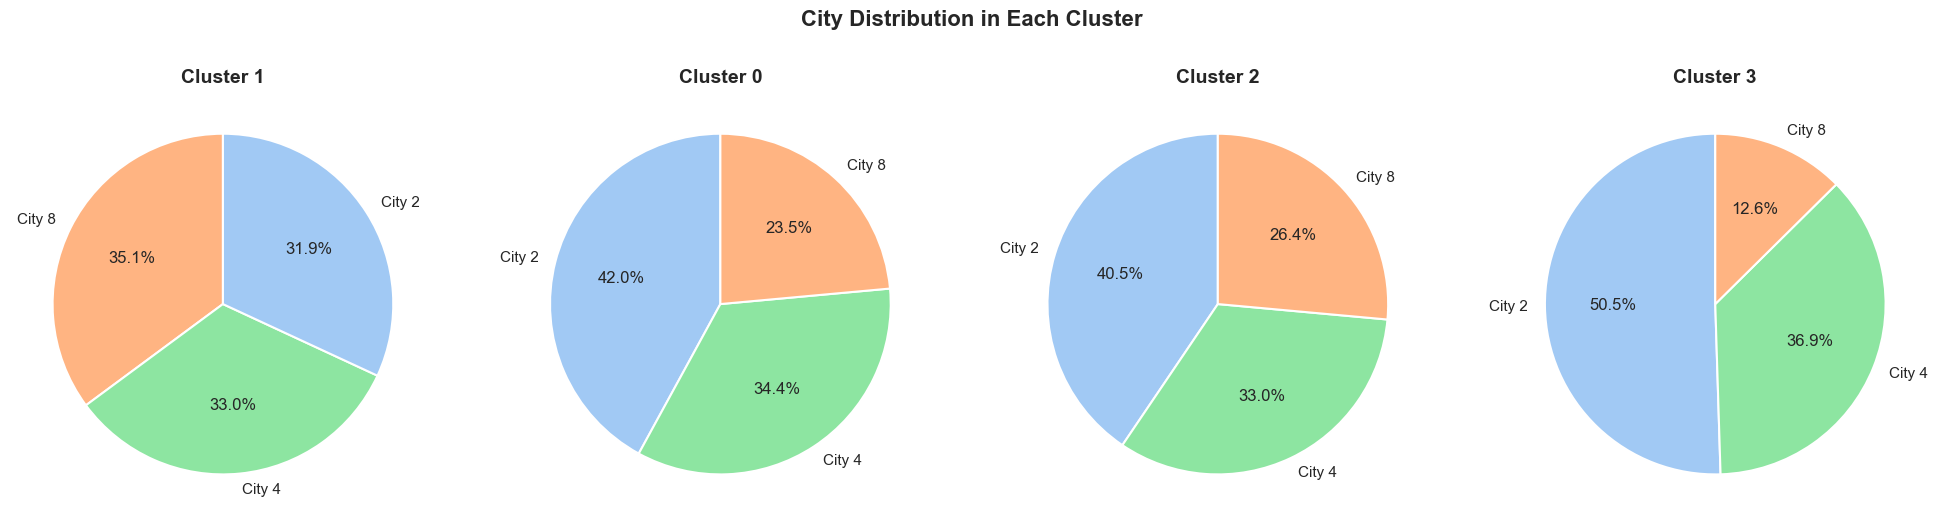

In [125]:
# Obter todas as cidades únicas e clusters únicos
unique_cities = cluster_df['customer_city'].unique()
unique_clusters = cluster_df['K_Means_4_clusters'].unique()

# Criar um mapa fixo de cores para cada cidade
color_palette = sns.color_palette("pastel", len(unique_cities))
city_color_map = {city: color_palette[i] for i, city in enumerate(unique_cities)}

# Criar a figura e os eixos
fig, axes = plt.subplots(1, len(unique_clusters), figsize=(20, 5))

# Gerar os gráficos de pizza para cada cluster
for i, cluster in enumerate(unique_clusters):
    # Filtrar os dados para o cluster atual e contar as cidades
    cluster_data = cluster_df[cluster_df['K_Means_4_clusters'] == cluster]['customer_city'].value_counts()
    
    # Criar uma lista de cores com base nas cidades do cluster
    colors = [city_color_map[city] for city in cluster_data.index]
    
    # Plotar o gráfico de pizza
    axes[i].pie(
        cluster_data, 
        labels=[f"City {city}" for city in cluster_data.index], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )
    axes[i].set_title(f'Cluster {cluster}', fontsize=14, weight='bold')

# Título principal e ajuste de layout
plt.suptitle('City Distribution in Each Cluster', fontsize=16, weight='bold', y=1.05)
plt.tight_layout()
plt.show()

### 5.3 Age as a Factor

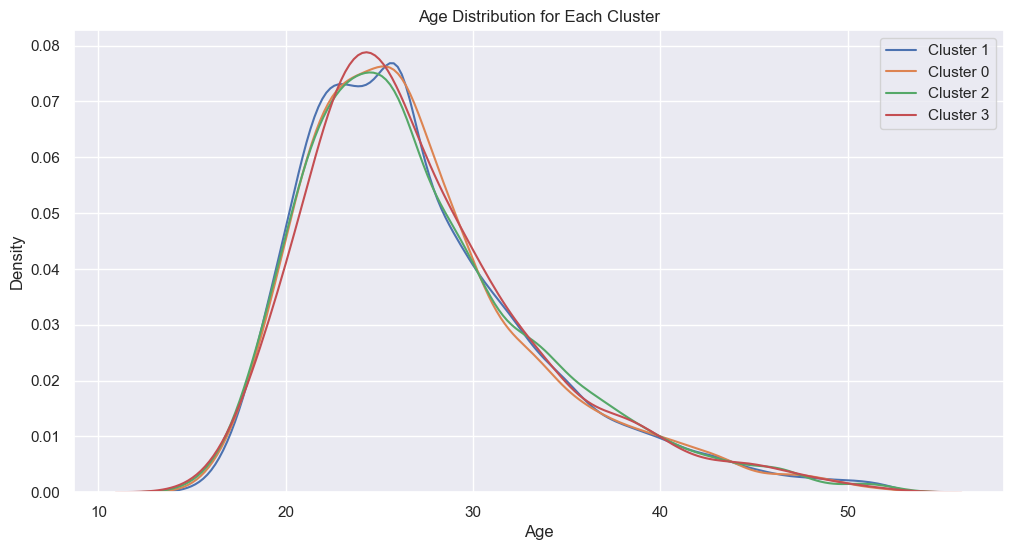

,mean,median
K_Means_4_clusters,,
0,27.149897,26.0
1,27.188522,26.0
2,27.278379,26.0
3,27.305634,26.0


In [126]:
plt.figure(figsize=(12, 6))

# Plot the distribution of age for each cluster
for cluster in cluster_df['K_Means_4_clusters'].unique():
    sns.kdeplot(cluster_df[cluster_df['K_Means_4_clusters'] == cluster]['customer_age'], label=f'Cluster {cluster}')

plt.title('Age Distribution for Each Cluster')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()
# Calculate and display the mean and median age for each cluster
mean_median_age = cluster_df.groupby('K_Means_4_clusters')['customer_age'].agg(['mean', 'median'])
mean_median_age


### 5.4 Payment Method as  Factor

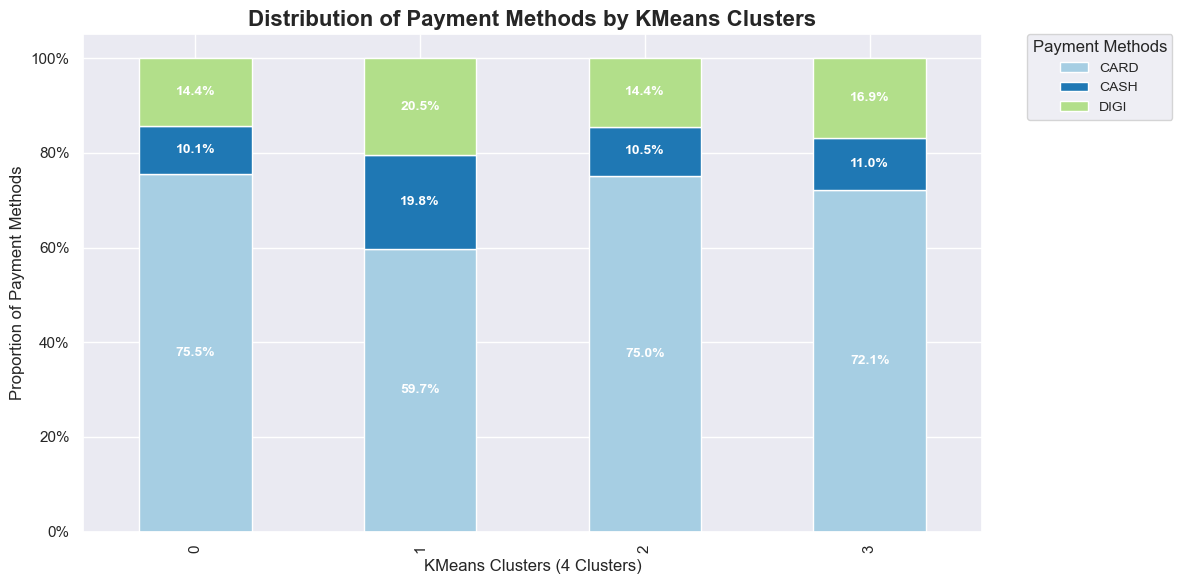

In [127]:
# Create the plot
ax = cluster_df.groupby('K_Means_4_clusters')['payment_method'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=plt.cm.Paired.colors  # Use a color map for consistent, appealing colors
)

# Add title and labels
plt.title("Distribution of Payment Methods by KMeans Clusters", fontsize=16, fontweight='bold')
plt.xlabel("KMeans Clusters (4 Clusters)", fontsize=12)
plt.ylabel("Proportion of Payment Methods", fontsize=12)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add percentage labels on each bar segment
for container in ax.containers:
    # Convert proportions to percentages and add labels
    labels = [f'{h * 100:.1f}%' if h > 0 else '' for h in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=10, color='white', weight='bold')

# Adjust legend - place it outside the plot
plt.legend(
    title="Payment Methods",
    title_fontsize=12,
    fontsize=10,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # Move the legend outside the plot
    borderaxespad=0
)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()



We can verify that in terms of payment methods, all clusters have a similar distribution, except for Cluster 1.

In all clusters, we find that the most commonly used payment method is with a card, the second is with DIGI, and the third is with CASH.

In Cluster 1, the difference between the DIGI and CASH payment methods is very small. Therefore, based on this analysis, we can conclude that customers in Cluster 1 use the CASH payment method more frequently, in percentage terms, compared to the other clusters.

### 5.5 Comparing Clusters with The Entire DataSet

In [129]:
columns_to_drop = ["customer_city", "payment_method", "K_Means_2_clusters", "K_Means_3_clusters", "Hierarchical_Clustering_3_Clusters", "Hierarchical_Clustering_4_Clusters"] + DOW_col
merged_df = pd.merge(cluster_df.drop(columns= columns_to_drop), df[new_features_list].drop(columns=["customer_city"]), left_index=True, right_index=True)
merged_df

,customer_age,K_Means_4_clusters,used_promo,order_count,avg_product_by_order,delta_day_order,tot_value_cui,order_freq,value_freq,product_freq,avg_order_value,avg_product_value
0,18.0,1,True,2,2.5,2.0,28.88,1.000000,14.440,2.500000,5.776,5.776
1,17.0,1,True,2,1.0,2.0,19.21,1.000000,9.605,1.000000,9.605,9.605
2,38.0,1,True,2,1.0,2.0,9.20,1.000000,4.600,1.000000,4.600,4.600
3,26.0,1,True,2,1.5,3.0,31.56,0.666667,10.520,1.000000,10.520,10.520
4,20.0,1,False,2,2.5,3.0,55.44,0.666667,18.480,1.666667,11.088,11.088
...,...,...,...,...,...,...,...,...,...,...,...,...
31883,30.0,1,True,1,1.0,1.0,18.04,1.000000,18.040,1.000000,18.040,18.040
31884,26.0,1,True,1,1.0,1.0,18.04,1.000000,18.040,1.000000,18.040,18.040
31885,24.0,1,False,1,1.0,1.0,17.79,1.000000,17.790,1.000000,17.790,17.790
31886,34.0,1,True,1,1.0,1.0,12.03,1.000000,12.030,1.000000,12.030,12.030


In [130]:
scaler = MinMaxScaler()

# Select the columns to be normalized (excluding non-numerical columns)
columns_to_normalize = remaining_columns = merged_df.drop(columns=["K_Means_4_clusters"]).columns

# Apply the scaler to the selected columns
merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

# Display the normalized dataframe
merged_df.head()

,customer_age,K_Means_4_clusters,used_promo,order_count,avg_product_by_order,delta_day_order,tot_value_cui,order_freq,value_freq,product_freq,avg_order_value,avg_product_value
0,0.081081,1,1.0,0.010753,0.3,0.011111,0.020106,0.245810,0.102119,0.177251,0.225062,0.225062
1,0.054054,1,1.0,0.010753,0.0,0.011111,0.013287,0.245810,0.067849,0.069936,0.384471,0.384471
2,0.621622,1,1.0,0.010753,0.0,0.011111,0.006227,0.245810,0.032375,0.069936,0.176103,0.176103
3,0.297297,1,1.0,0.010753,0.1,0.022222,0.021996,0.162011,0.074334,0.069936,0.422565,0.422565
4,0.135135,1,0.0,0.010753,0.3,0.022222,0.038837,0.162011,0.130753,0.117631,0.446211,0.446211


In [131]:
group_means = merged_df.groupby('K_Means_4_clusters').mean().T

# Calculate the overall mean of the DataFrame (excluding the 'labels' column)
overall_mean = pd.DataFrame(merged_df.drop(columns='K_Means_4_clusters').mean()) # Transpose to match the shape for concatenation

# Concatenate the two DataFrames horizontally
result = pd.concat([group_means, overall_mean], axis=1)
result.columns = list(result.columns[:-1]) + ['Overall Mean']

result

,0,1,2,3,Overall Mean
customer_age,0.328376,0.329420,0.331848,0.332585,0.329701
used_promo,0.367214,0.509684,0.369494,0.319718,0.474459
order_count,0.078533,0.015278,0.087743,0.286703,0.036431
avg_product_by_order,0.062463,0.059471,0.060658,0.062041,0.059957
delta_day_order,0.701312,0.285953,0.725528,0.898529,0.393873
tot_value_cui,0.047673,0.016833,0.052781,0.133483,0.026870
order_freq,0.029334,0.098836,0.032315,0.080883,0.083574
value_freq,0.007810,0.037743,0.008558,0.016529,0.030798
product_freq,0.011466,0.038460,0.012445,0.030787,0.032494
avg_order_value,0.238489,0.319954,0.243003,0.202707,0.300023


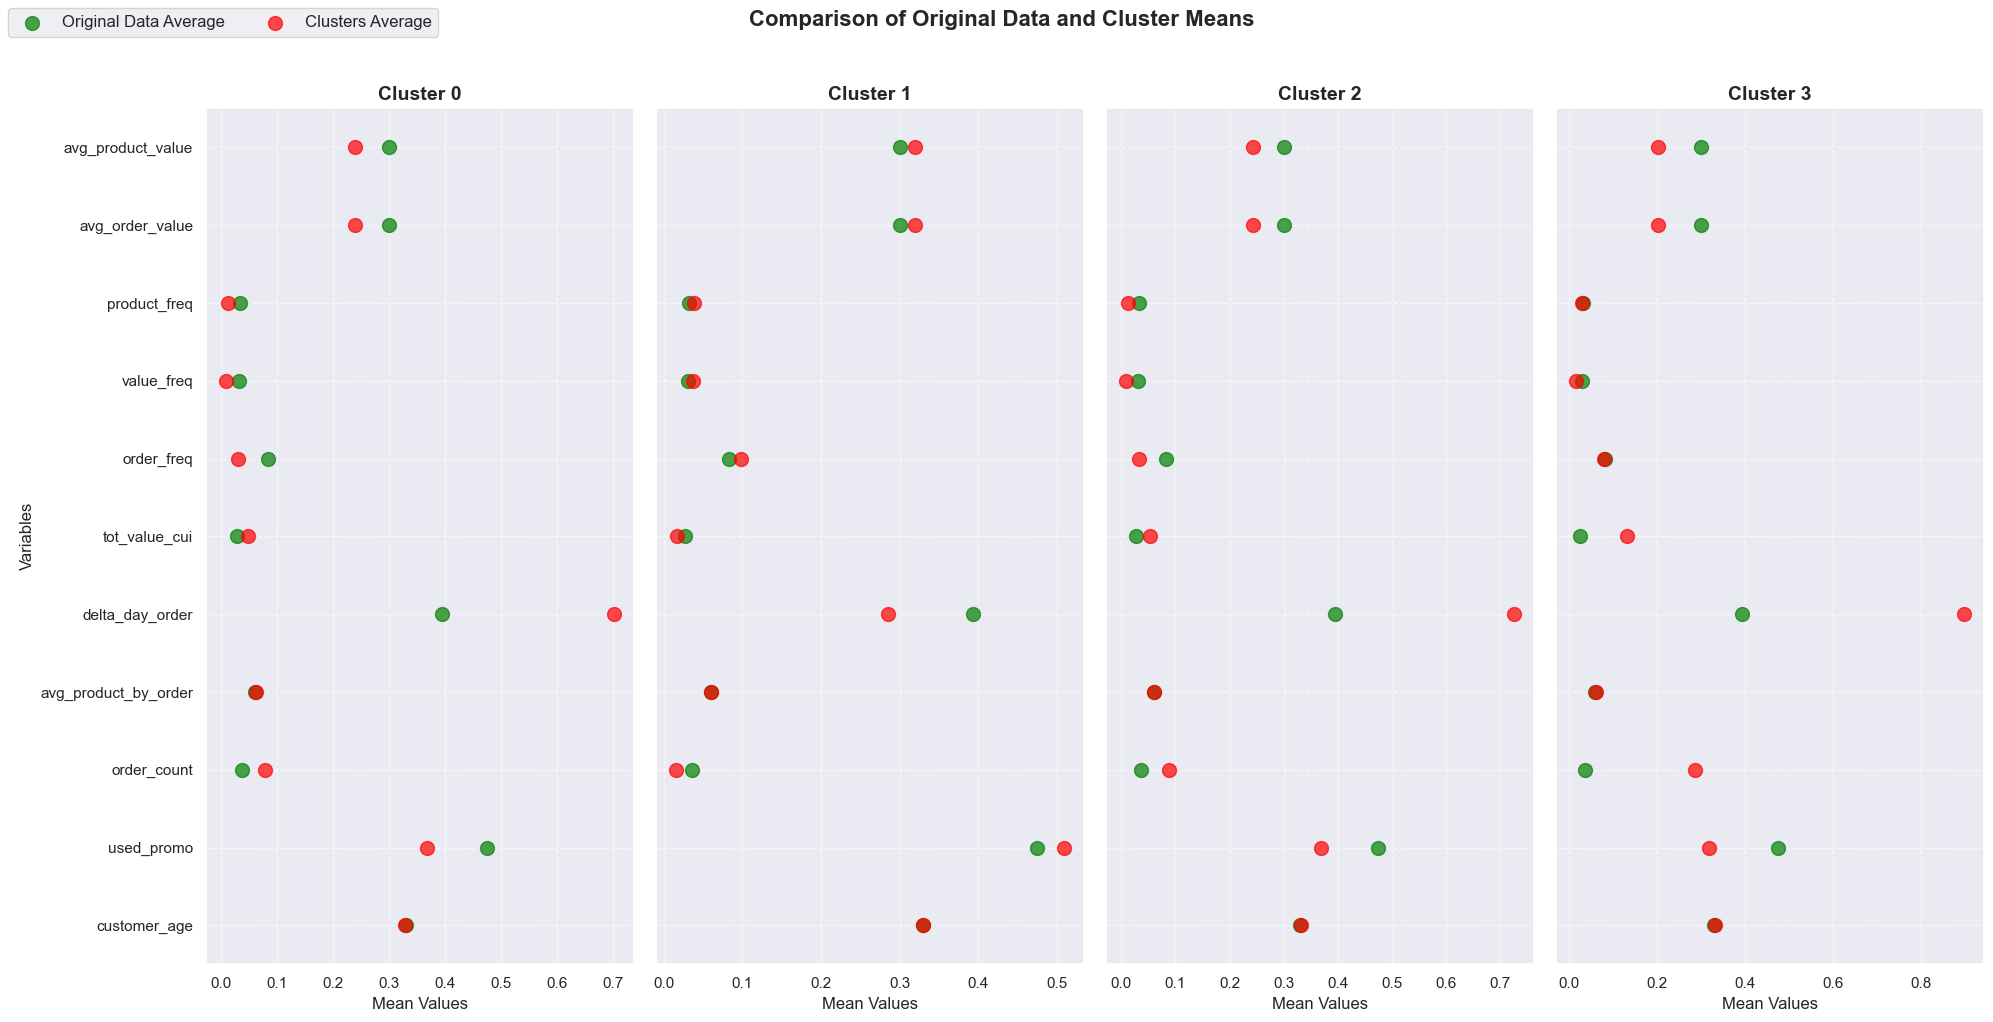

In [132]:
original_data_means = result['Overall Mean']
cluster_means = {
    0: result[0],
    1: result[1],
    2: result[2],
    3: result[3]
}

# Variables (replace with your variable names)
variables = result.index.to_list()

# Plotting
fig, axes = plt.subplots(1, len(cluster_means), figsize=(20, 10), sharey=True)

for cluster, ax in zip(cluster_means.keys(), axes):
    # Scatter plot for the database means
    ax.scatter(original_data_means, variables, color='green', label='Original Data Average', s=100, alpha=0.7)
    
    # Scatter plot for the cluster means
    ax.scatter(cluster_means[cluster], variables, color='red', label=f'Clusters Average', s=100, alpha=0.7)
    
    # Titles and labels
    ax.set_title(f'Cluster {cluster}', fontsize=14, weight='bold')
    ax.set_xlabel('Mean Values', fontsize=12)
    if cluster == 0:
        ax.set_ylabel('Variables', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Add a shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=12)  # Change the location here

# Add a main title
fig.suptitle('Comparison of Original Data and Cluster Means', fontsize=16, weight='bold', y=1.02)

plt.tight_layout()
plt.show()

### 4.4 Final Cluster Profile

| Cluster | Key Characteristics | Potential Marketing Strategy |
|---|---|---|
| **Cluster 0: End of the Week Shoopers (9.3%)** | Customers show medium activity during the week, with a significant increase in orders on Friday and Saturday. Their peak occurs on Saturday. | Loyalty programs with exclusive rewards; Personalized recommendations based on past purchases; Targeted promotions for Friday and Saturday to capitalize on weekend shopping trends. |
| **Cluster 1: Low Orders Shoopers (75.8%)** | Customers place the fewest orders with consistent low activity throughout the week, peaking on Saturday but with minimal variation. In addition, this cluster is the only one that has his delta day order average lower than the overall dataset average. Also this are the clients that used more promotions.| Retention-focused strategies; Personalized offers and discounts; Targeted email campaigns promoting new products and weekend deals to encourage more frequent purchasing. |
| **Cluster 2: Weekdays Shoopers (12.6%)** | High and uniform activity across Sunday and weekdays, peaking on Tuesday and Wednesday, with a decline towards the weekend. | Loyalty programs with tiered rewards for midweek purchases; Personalized email campaigns featuring curated product selections for the workweek; Highlighting new products on Tuesday and Wednesday. |
| **Cluster 3: High Activity Shoopers (2.3%)** | Customers exhibit high purchasing activity throughout the week, peaking on Wednesday. Besides that the average of the delta day order and the total money spent are bigger than the overall averages of the dataset, what indicates that the clients that place more orders are also the one who have been purchasing from the company for a longer period and spend more money on purchases compared to other customers. | Exclusive deals for high-frequency shoppers. |


### Age as a Factor

Interestingly, the analysis suggests that age does not significantly influence the clustering. As we can see the distribution of the age are very simillar across the different clusters. This indicates that purchasing patterns are more strongly driven by other factors, such as lifestyle, preferences, and habits.

### City as a Factor

We can see that city 2 has the greatest impact on the number of orders placed by customers. The clusters with the lowest activity, namely 1, is the one that have a more uniform distribution of the population across the three cities. As the population from city 2 increases in percentage relative to the others, we observe an increase in activity, which suggests that the residents of this city are the most active customers.

### Payment Method as Factor

We can verify that in terms of payment methods, all clusters have a similar distribution, except for Cluster 1.

In all clusters, we find that the most commonly used payment method is with a card, the second is with DIGI, and the third is with CASH.

In Cluster 1, the difference between the DIGI and CASH payment methods is very small. Therefore, based on this analysis, we can conclude that customers in Cluster 1 use the CASH payment method more frequently, in percentage terms, compared to the other clusters.

